# Data Understanding

Dataset: 
1) https://github.com/kennqiang/MDFEND-Weibo21/tree/main/data
2) https://github.com/Xovee/ccgl

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jieba.posseg as pseg
from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_json('C:/Users/User/OneDrive - Universiti Malaya/CHEF/train.json')
df1 = pd.read_json('C:/Users/User/OneDrive - Universiti Malaya/CHEF/test.json')
df2 = pd.read_json('C:/Users/User/OneDrive - Universiti Malaya/CHEF/dev.json')

In [3]:
dfs = [df, df1, df2]

# Concatenate DataFrames vertically (along rows)
combined_df = pd.concat(dfs, ignore_index=True)

# Print the combined DataFrame
combined_df.head()

,claim,title,source,claimWeb,category,url,publish_date,editor,label,claimId,domain,verification method,evidence,gold evidence,verification社会ethod
0,新疆棉花生产已实现高度机械化，不需要强迫劳动。,中使馆驳斥涉疆谣言：新疆棉花生产已实现高度机械化，哪里还需要强迫劳动？,中国驻英国使馆网站,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2021-03/25/c_12110818...,2021-03-25,谢博隆,0,5,政治,专家咨询,{'0': {'text': '2021年3月22日，驻英国使馆杨晓光临时代办先后接受英国天...,{'0': {'text': '新疆棉花生产早已经实现高度机械化，即使在忙碌的采摘季节，也不...,NaN
1,失业保险金不等于失业补助金。,关于失业保险金，你可能有太多误区,中国互联网联合辟谣平台,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2020-10/29/c_12108633...,2020-10-29,殷荧,0,27,社会,证据搜集,{'0': {'text': '由内容质量、互动评论、分享传播等多维度分值决定，勋章级别越高...,"{'0': {'text': '答：按政策规定，失业保险金和失业补助金不可以同时领取。'},...",NaN
2,退休职工养老金能按时足额发放。,退休职工养老金能否按时足额发放？人社部回应了！,新华社,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2020-10/29/c_12108629...,2020-10-29,殷荧,0,32,社会,专家咨询,{'0': {'text': '新华社北京10月28日电（记者姜琳）今年社保费减免力度空前，...,{'0': {'text': '人力资源和社会保障部28日回应，保发放提前进行了准备和安排，...,NaN
3,中国污水处理能力限制城市发展。,污水处理能力限制城市发展？ 补齐设施短板！,科技日报,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2020-08/20/c_12107612...,2020-08-20,冯栋,0,38,社会,证据搜集,{'0': {'text': '原标题：为打赢污染防治攻坚战，《城镇生活污水处理设施补短板强...,{'0': {'text': '原标题：为打赢污染防治攻坚战，《城镇生活污水处理设施补短板强...,NaN
4,截至2020年3月底，猪肉价格持续小幅下跌。,这场发布会回应“舌尖上”的问题,科技日报,中国互联网辟谣平台,部委发布,https://www.piyao.org.cn/2020-04/20/c_12105781...,2020-04-20,殷荧,0,63,社会,专家咨询， 数值推理,{'0': {'text': '原标题：截至3月底，猪肉批发价格已连续7周下跌来源：新京报全...,{'0': {'text': '陈萍提出，分品种看，猪肉价格持续小幅下跌，截至3月底全国猪肉...,NaN


In [4]:
label_counts = combined_df['label'].value_counts()

print(label_counts)

label
1    5015
0    3543
2    1442
Name: count, dtype: int64


In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   claim                10000 non-null  object
 1   title                10000 non-null  object
 2   source               10000 non-null  object
 3   claimWeb             10000 non-null  object
 4   category             10000 non-null  object
 5   url                  10000 non-null  object
 6   publish_date         10000 non-null  object
 7   editor               10000 non-null  object
 8   label                10000 non-null  int64 
 9   claimId              10000 non-null  int64 
 10  domain               10000 non-null  object
 11  verification method  9999 non-null   object
 12  evidence             10000 non-null  object
 13  gold evidence        10000 non-null  object
 14  verification社会ethod  1 non-null      object
dtypes: int64(2), object(13)
memory usage: 1.1+ MB


In [6]:
combined_df = combined_df.drop(columns=['verification社会ethod'])

combined_df = combined_df[combined_df['label'] != 2]

In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8558 entries, 0 to 9666
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   claim                8558 non-null   object
 1   title                8558 non-null   object
 2   source               8558 non-null   object
 3   claimWeb             8558 non-null   object
 4   category             8558 non-null   object
 5   url                  8558 non-null   object
 6   publish_date         8558 non-null   object
 7   editor               8558 non-null   object
 8   label                8558 non-null   int64 
 9   claimId              8558 non-null   int64 
 10  domain               8558 non-null   object
 11  verification method  8557 non-null   object
 12  evidence             8558 non-null   object
 13  gold evidence        8558 non-null   object
dtypes: int64(2), object(12)
memory usage: 1002.9+ KB


In [8]:
combined_df.isnull().any()

claim                  False
title                  False
source                 False
claimWeb               False
category               False
url                    False
publish_date           False
editor                 False
label                  False
claimId                False
domain                 False
verification method     True
evidence               False
gold evidence          False
dtype: bool

In [9]:
combined_df['verification method'].fillna("Not applicable", inplace=True)

In [10]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8558 entries, 0 to 9666
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   claim                8558 non-null   object
 1   title                8558 non-null   object
 2   source               8558 non-null   object
 3   claimWeb             8558 non-null   object
 4   category             8558 non-null   object
 5   url                  8558 non-null   object
 6   publish_date         8558 non-null   object
 7   editor               8558 non-null   object
 8   label                8558 non-null   int64 
 9   claimId              8558 non-null   int64 
 10  domain               8558 non-null   object
 11  verification method  8558 non-null   object
 12  evidence             8558 non-null   object
 13  gold evidence        8558 non-null   object
dtypes: int64(2), object(12)
memory usage: 1002.9+ KB


In [11]:
combined_df['label'].value_counts()

label
1    5015
0    3543
Name: count, dtype: int64

# EDA

In [12]:
def map_labels(label):
    if label == 0:
        return 'Fake'
    elif label == 1:
        return 'True'
    else:
        return 'unknown'  # Handle other cases if needed

# Apply the function to create a new column
EDA_df=combined_df.copy()
EDA_df['label_meaning'] = combined_df['label'].apply(map_labels)

C:\Users\User\AppData\Local\Temp\ipykernel_6200\3733478073.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=custom_palette)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


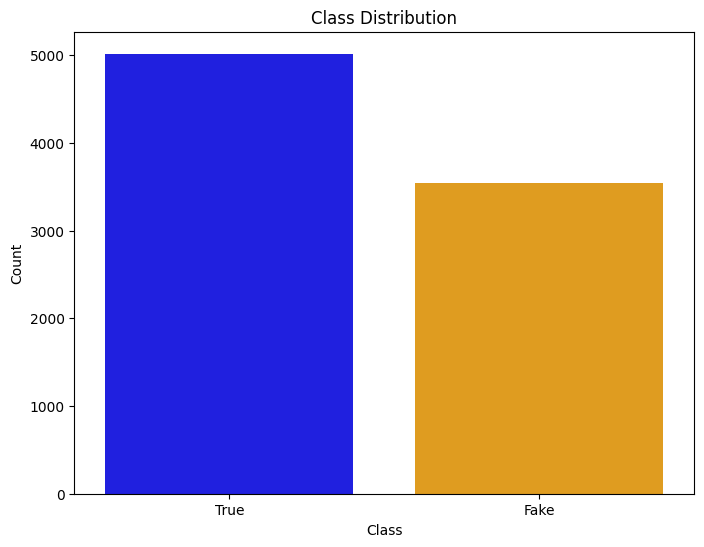

In [13]:
class_counts = EDA_df['label_meaning'].value_counts()

# Create a custom color palette
custom_palette = ['blue','orange']

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=custom_palette)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend().remove()
plt.show()

In [14]:
EDA_df['publish_date'] = df['publish_date'].str.replace("/", "-")

EDA_df['publish_date'] = pd.to_datetime(EDA_df["publish_date"], errors = "coerce")

# Extract year and month to a new column
EDA_df['year_month'] = EDA_df['publish_date'].dt.to_period('M')

# Change the data type from Period to string
EDA_df['year_month'] = EDA_df['year_month'].astype(str)


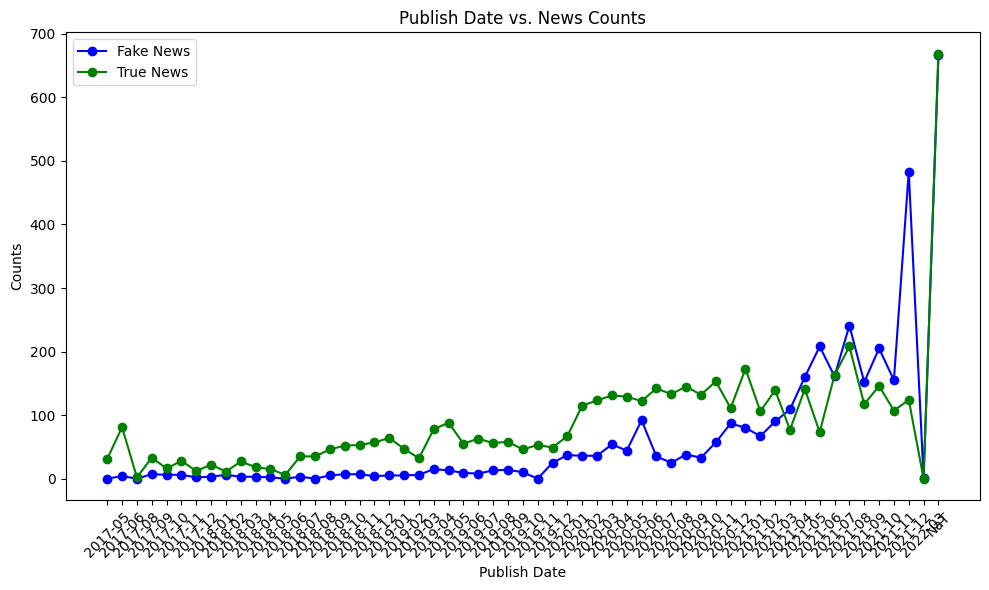

In [15]:
news_counts = EDA_df.groupby(['year_month', 'label_meaning']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the line graphs for fake news and true news counts
plt.plot(news_counts.index, news_counts['Fake'], marker='o', linestyle='-', color='b', label='Fake News')
plt.plot(news_counts.index, news_counts['True'], marker='o', linestyle='-', color='g', label='True News')

# Customize the plot
plt.title('Publish Date vs. News Counts')
plt.xlabel('Publish Date')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

plt.tight_layout()  # Adjust layout for better appearance
plt.show()  # Display the plot

# Data Preprocessing

Remove IP addresses, stop words and punctuation
Tokenization

In [16]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [17]:
def process(data):
    res = data.apply(jieba_tokenizer)
    return res

In [18]:
jieba_df = combined_df[["claim", "title", "label"]]

jieba_df.head()

,claim,title,label
0,新疆棉花生产已实现高度机械化，不需要强迫劳动。,中使馆驳斥涉疆谣言：新疆棉花生产已实现高度机械化，哪里还需要强迫劳动？,0
1,失业保险金不等于失业补助金。,关于失业保险金，你可能有太多误区,0
2,退休职工养老金能按时足额发放。,退休职工养老金能否按时足额发放？人社部回应了！,0
3,中国污水处理能力限制城市发展。,污水处理能力限制城市发展？ 补齐设施短板！,0
4,截至2020年3月底，猪肉价格持续小幅下跌。,这场发布会回应“舌尖上”的问题,0


In [19]:
jieba_df.isna().any()

claim    False
title    False
label    False
dtype: bool

In [20]:
jieba_df["tokenized_claim"] = process(jieba_df.loc[:,"claim"])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.487 seconds.
Prefix dict has been built successfully.
C:\Users\User\AppData\Local\Temp\ipykernel_6200\1546768494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jieba_df["tokenized_claim"] = process(jieba_df.loc[:,"claim"])


In [21]:
jieba_df["tokenized_title"] = process(jieba_df.loc[:,"title"])

C:\Users\User\AppData\Local\Temp\ipykernel_6200\4142103444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jieba_df["tokenized_title"] = process(jieba_df.loc[:,"title"])


In [22]:
jieba_df.head()

,claim,title,label,tokenized_claim,tokenized_title
0,新疆棉花生产已实现高度机械化，不需要强迫劳动。,中使馆驳斥涉疆谣言：新疆棉花生产已实现高度机械化，哪里还需要强迫劳动？,0,新疆 棉花 生产 已 实现 高度 机械化 不 需要 强迫 劳动,中 使馆 驳斥 涉疆 谣言 新疆 棉花 生产 已 实现 高度 机械化 哪里 还 需要 强迫 劳动
1,失业保险金不等于失业补助金。,关于失业保险金，你可能有太多误区,0,失业 保险金 不 等于 失业 补助金,关于 失业 保险金 你 可能 有 太 多 误区
2,退休职工养老金能按时足额发放。,退休职工养老金能否按时足额发放？人社部回应了！,0,退休职工 养老金 能 按时 足额 发放,退休职工 养老金 能否 按时 足额 发放 人社部 回应 了
3,中国污水处理能力限制城市发展。,污水处理能力限制城市发展？ 补齐设施短板！,0,中国 污水处理 能力 限制 城市 发展,污水处理 能力 限制 城市 发展 补齐 设施 短板
4,截至2020年3月底，猪肉价格持续小幅下跌。,这场发布会回应“舌尖上”的问题,0,截至 2020 年 3 月底 猪肉 价格 持续 小幅 下跌,这场 发布会 回应 舌尖 上 的 问题


In [23]:
jieba_df.isna().any()

claim              False
title              False
label              False
tokenized_claim    False
tokenized_title    False
dtype: bool

In [24]:
import math

train_num = math.ceil(len(jieba_df)*0.8)

jieba_df = jieba_df.sample(frac = 1)

jieba_df_train = jieba_df.head(train_num)

jieba_df_test = jieba_df.tail(len(jieba_df) - train_num)

In [25]:
jieba_df_train

,claim,title,label,tokenized_claim,tokenized_title
707,汪文斌：美国炒作“实验室泄漏是美一己私利，损害的是国际公益和各国人民的生命健康。,汪文斌：美国炒作“实验室泄漏说”到底意欲何为？,0,汪文斌 美国 炒作 实验室 泄漏 是 美 一己 私利 损害 的 是 国际 公益 和 各国 人...,汪文斌 美国 炒作 实验室 泄漏 说 到底 意欲何为
3375,2018年8月，山西大同两人因房屋漏水引发矛盾，男子把女邻居砍死。,馒头掺卫生纸？8月谣言：老套路 新花样,1,2018 年 8 月 山西大同 两 人 因 房屋 漏水 引发 矛盾 男子 把 女 邻居 砍死,馒头 掺 卫生纸 8 月 谣言 老套路 新花样
3524,飞机有辐射孕妇不能乘坐。,假期将至，这些关于旅游的谣言你信了吗？,1,飞机 有 辐射 孕妇 不能 乘坐,假期 将 至 这些 关于 旅游 的 谣言 你 信 了 吗
8355,车管所年审新规：车辆逾期未检，车管所将予以锁定，需要车主本人去车管部门处理，才能解锁,千万别信！近期朋友圈十大谣言！第一个就骗了很多人,1,车管所 年 审新 规 车辆 逾期 未 检 车管所 将 予以 锁定 需要 车主 本人 去 车管...,千万别 信 近期 朋友圈 十大 谣言 第一个 就 骗 了 很多 人
2375,2020年5月27日，美股集体收高道指涨逾520点，瑞幸咖啡大涨53%。,,0,2020 年 5 月 27 日 美股 集体 收高 道 指涨 逾 520 点 瑞幸 咖啡 大 ...,
...,...,...,...,...,...
5737,2021 年 1 月 14 日時，有网友爆料台南市史博館路口發生假車禍與假警察事件。,【查證】台南市史博館路口發生假車禍與假警察事件？警：勿轉傳未經證實訊息,1,2021 年 月 14 日時 有 网友 爆料 台南市 史博館 路口 發生 假車 禍 與 假警...,查證 台南市 史博館 路口 發生 假車 禍 與 假警察 事件 警 勿 轉傳 未經 證實訊息
3208,微信免费时代即将结束。,这些谣言中老年人要当心,1,微信 免费 时代 即将 结束,这些 谣言 中老年人 要 当心
6026,俄羅斯在街上放獅子防止民眾外出,【假圖片】俄羅斯在街上放獅子防止民眾外出？2016電影場景,1,俄羅斯 在 街上 放 獅子 防止 民眾 外出,假 圖片 俄羅斯 在 街上 放 獅子 防止 民眾 外出 2016 電影場 景
646,新疆人权成果再次捅破西方炮制的弥天大谎，西方一些人权卫士的乱疆遏华图谋必定一败涂地,新疆人权成果再次捅破西方炮制的弥天大谎,0,新疆 人权 成果 再次 捅破 西方 炮制 的 弥天大谎 西方 一些 人权 卫士 的 乱疆遏 ...,新疆 人权 成果 再次 捅破 西方 炮制 的 弥天大谎


In [26]:
jieba_df_test

,claim,title,label,tokenized_claim,tokenized_title
6857,疫苗不起作用。,【錯誤】網傳圖片「英國數據 不應該讓你孩子打新冠疫苗13個理由」？,1,疫苗 不起作用,錯誤 網傳 圖片 英國 數據 不 應 該 讓 你 孩子 打新 冠 疫苗 13 個 理由
8630,乾咳加打噴嚏加其他症狀就等於冠狀病毒,【易誤解】乾咳加打噴嚏加其他症狀就等於冠狀病毒？衛福部：不能這樣診斷,1,乾咳 加打 噴嚏 加 其他 症狀 就 等 於冠狀 病毒,易 誤解 乾咳 加打 噴嚏 加 其他 症狀 就 等 於冠狀 病毒 衛福部 不能 這樣 診斷
5517,"陳昭輝醫師和華通電訊有限公司真的匯給你錢,可是事後地下錢莊來催討。","【假LINE】真的匯給你錢,可是事後地下錢莊來催討？陳昭輝醫師、華通電訊躺著也中槍",1,陳昭輝 醫師 和 華通 電訊 有限公司 真的 匯 給 你 錢 可是 事 後 地下 錢莊 來 催討,假 LINE 真的 匯 給 你 錢 可是 事 後 地下 錢莊 來 催討 陳昭輝 醫師 華通 ...
4778,立百病毒具有超強抗生素抗藥性；在中國、亞洲已經爆發。,【錯誤】台灣外電新聞稱「立百病毒具有超強抗生素抗藥性；在中國、亞洲已經爆發」?,1,立百 病毒 具有 超強 抗生素 抗藥 性 在 中國 亞洲 已經 爆發,錯誤 台灣 外電 新聞 稱 立百 病毒 具有 超強 抗生素 抗藥 性 在 中國 亞洲 已經 爆發
845,如果把人类基因演化的过程想象成一棵树，末次盛冰期之前的东亚人，即田园洞人相关人群，和现代东亚...,冰河时期的东亚人和我们是一种人吗？,0,如果 把 人类基因 演化 的 过程 想象 成 一棵树 末次 盛 冰期 之前 的 东亚人 即 ...,冰河时期 的 东亚人 和 我们 是 一种 人 吗
...,...,...,...,...,...
9609,含代可可脂的巧克力一定健康,"高钙奶真的更补钙？小心食品包装上竟藏着这些""陷阱""",1,含代 可可 脂的 巧克力 一定 健康,高 钙奶 真的 更 补钙 小心 食品包装 上 竟 藏 着 这些 陷阱
1517,中国专家研发新型脊柱内镜手术技术，提高安全性和效率。,,0,中国 专家 研发 新型 脊柱 内镜 手术 技术 提高 安全性 和 效率,
1979,《当家主母》开播，茅子俊再演古装搭档蒋勤勤。,,0,当家 主母 开播 茅子 俊 再演 古装 搭档 蒋勤勤,
4015,2018年3月苏家屯出现人贩子。,苏家屯出现人贩子？ 网警辟谣：假的！,1,2018 年 3 月 苏家屯 出现 人贩子,苏家屯 出现 人贩子 网警 辟谣 假 的


# Feature Extraction

Transform train and test dataset into numerical feature

In [27]:
MAX_NUM_WORDS = 10000
tokenizer = keras \
    .preprocessing \
    .text \
    .Tokenizer(num_words=MAX_NUM_WORDS)

In [28]:
corpus_train = jieba_df_train.tokenized_claim + jieba_df_train.tokenized_title
corpus_test = jieba_df_test.tokenized_claim + jieba_df_test.tokenized_title

In [29]:
print(corpus_train.isna().any())
print(corpus_test.isna().any())

False
False


In [30]:
# Convert text to numerical
tokenizer.fit_on_texts(corpus_train)
x_train = tokenizer \
    .texts_to_sequences(corpus_train)

x_test = tokenizer \
    .texts_to_sequences(
        corpus_test)

In [31]:
x_train[1]

[83,
 2,
 47,
 3,
 786,
 13,
 98,
 9408,
 4818,
 526,
 7583,
 389,
 118,
 423,
 7584,
 5741,
 47,
 3,
 17,
 4080,
 4081]

In [32]:
for seq in x_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['汪文斌', '美国', '炒作', '实验室', '泄漏', '是', '美', '一己', '私利', '损害', '的', '是', '国际', '公益', '和', '各国', '人民', '的', '生命', '美国', '炒作', '实验室', '泄漏', '说', '到底']


In [33]:
# Add zero padding
MAX_SEQUENCE_LENGTH = 30

x_train = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(x_train, 
                   maxlen=MAX_SEQUENCE_LENGTH)

x_test = keras \
    .preprocessing \
    .sequence \
    .pad_sequences(
        x_test, 
        maxlen=MAX_SEQUENCE_LENGTH)

In [34]:
print(x_train[9])
print(x_test[9])

[   0    0    0    0    0    0    0    0  739 5744 4822 4087    1  883
 5745    5  929 5746  739 5744 4822 5745    5  929 5746 7587   15   78
   37 4088]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  400   42 4043  431  151   42 4043
  431   65]


In [35]:
# Check if the sequence length of news is 30
for seq in x_train:
    assert len(seq) == 30
    
print("all sequence length of news 30 !")


for seq in x_test:
    assert len(seq) == 30
    
print("all sequence length of news 30 !")

all sequence length of news 30 !
all sequence length of news 30 !


Transform y-train into numerical feature

In [36]:
y_train = np.asarray(jieba_df_train["label"]).astype('float32')

# One-hot Encoding
y_train = keras \
    .utils \
    .to_categorical(y_train)

y_train[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [37]:
from sklearn.model_selection import train_test_split

VALIDATION_RATIO = 0.2

RANDOM_STATE = 4444

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)

In [38]:
x_val

array([[   0,    0,    0, ..., 1273, 1163,    1],
       [   0,    0,    0, ...,  166, 2351,  906],
       [   0,    0,    0, ...,   15,  579,  279],
       ...,
       [   0,    0,    0, ...,  952,   23,  996],
       [   0,    0,    0, ..., 2566, 3775,  821],
       [   0,    0,    0, ...,   56, 5665, 7370]])

In [39]:
print("Training Set")
print("-" * 10)
print(f"x_train: {x_train.shape}")
print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x1_val:   {x_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x_train: (5477, 30)
y_train : (5477, 2)
----------
x1_val:   (1370, 30)
y_val :   (1370, 2)
----------
Test Set


## Word2Vec

In [40]:
w2v_train = jieba_df.tokenized_claim + jieba_df.tokenized_title

In [41]:
from gensim.models import Word2Vec

# Assuming "sentences" is a list of tokenized sentences
model_word2vec = Word2Vec(w2v_train, vector_size=256, window=5, min_count=5, sg=0)

C:\Users\User\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [42]:
# Save the Word2Vec model
model_word2vec.save("C:/Users/User/Downloads/word2vec_model")

In [43]:
model_word2vec = Word2Vec.load("C:/Users/User/Downloads/word2vec_model")

In [44]:
similar_words = model_word2vec.wv.most_similar("新", topn=5)
for word, score in similar_words:
    print(word, score)

佳 0.5670649409294128
脉 0.5338876247406006
严 0.443361759185791
正 0.42332392930984497
夺 0.40579527616500854


In [45]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 256))  # Assuming 256 is the vector size

for word, i in tokenizer.word_index.items():
    if word in model_word2vec.wv:
        embedding_matrix[i] = model_word2vec.wv[word]

# Modeling

In [46]:
# Create empty list for performance comparison
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Create a function to append the result to the list
def performance_comparison(y_test, model):
    a = accuracy_score(y_test, model)
    p =precision_score(y_test, model)
    r =recall_score(y_test, model)
    f =f1_score(y_test, model)
    
    accuracies.append(round(a, 4) * 100)
    precisions.append(round(p, 4) * 100)
    recalls.append(round(r, 4) * 100)
    f1_scores.append(round(f, 4) * 100)

In [47]:
# Batch size for model training
BATCH_SIZE = 512

# Times for repeat training
NUM_EPOCHS = 50

def model_training(model, y_test):
    # Configure the training process
    lr = 1e-3
    opt = Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    # Actual training model
    history = model.fit(
        # Input 1 numbers of sequence length 30
        x=x_train, 
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,

        # Loss and accuracy after epoch validation
        validation_data=(
            x_val, 
            y_val
        ),
        # Shuffle the data
        shuffle=True
    )
    
    model_prediction = model.predict(x_test)
    model_prediction_int = np.argmax(model_prediction, axis=1)
    
    performance_comparison(y_test, model_prediction_int)

In [48]:
# Get the label from data frame
y_test_int = jieba_df_test["label"]

# Create a function for performance evaluation
def model_prediction(model, y_test):
    model_prediction = model.predict(x_test)
    model_prediction_int = np.argmax(model_prediction, axis=1)
    
    # Classification Report
    report = classification_report(y_test, model_prediction_int, digits=4)
    print("-"*80)
    print(report)
    
    # Get unique class labels from the true labels
    class_labels = np.unique(y_test)

    # Display the confusion matrix
    cm = confusion_matrix(y_test, model_prediction_int)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', values_format='d')
    print("-"*80)
    plt.show()


## LSTM

In [49]:
# Number of Class
NUM_CLASSES = 2

# Maximum number of words in Dict
MAX_NUM_WORDS = 10000

# Maximum sequence length of news
MAX_SEQUENCE_LENGTH = 30

# Embedding Dimension
NUM_EMBEDDING_DIM = 256

# Number of LSTM units
NUM_LSTM_UNITS = 128

In [50]:
# Model building (Siamese LSTM)

# Define a single input for sequences
input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Embedding
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
embedded_sequence = embedding_layer(input_sequence)

# LSTM
shared_lstm = LSTM(NUM_LSTM_UNITS)
sequence_output = shared_lstm(embedded_sequence)

# Dense layer for classification
output_layer = Dense(units=NUM_CLASSES, activation='softmax')
predictions = output_layer(sequence_output)


# Model Creation
model_lstm = Model(inputs=input_sequence, outputs=predictions)

model_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 256)           2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 2757378 (10.52 MB)
Trainable params: 2757378 (10.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model_training(model_lstm, y_test_int)

Epoch 1/50
11/11 [==============================] - 6s 353ms/step - loss: 0.6425 - accuracy: 0.6863 - val_loss: 0.5634 - val_accuracy: 0.7255
Epoch 2/50
11/11 [==============================] - 4s 344ms/step - loss: 0.4090 - accuracy: 0.8297 - val_loss: 0.3575 - val_accuracy: 0.8569
Epoch 3/50
11/11 [==============================] - 4s 351ms/step - loss: 0.2080 - accuracy: 0.9211 - val_loss: 0.3177 - val_accuracy: 0.8832
Epoch 4/50
11/11 [==============================] - 3s 300ms/step - loss: 0.1067 - accuracy: 0.9659 - val_loss: 0.3472 - val_accuracy: 0.8839
Epoch 5/50
11/11 [==============================] - 3s 283ms/step - loss: 0.0534 - accuracy: 0.9828 - val_loss: 0.4193 - val_accuracy: 0.8715
Epoch 6/50
11/11 [==============================] - 3s 318ms/step - loss: 0.0316 - accuracy: 0.9905 - val_loss: 0.5568 - val_accuracy: 0.8686
Epoch 7/50
11/11 [==============================] - 4s 334ms/step - loss: 0.0190 - accuracy: 0.9943 - val_loss: 0.5376 - val_accuracy: 0.8642
Epoch 

54/54 [==============================] - 0s 8ms/step
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8361    0.8431    0.8396       714
           1     0.8870    0.8816    0.8843       997

    accuracy                         0.8656      1711
   macro avg     0.8615    0.8624    0.8620      1711
weighted avg     0.8658    0.8656    0.8657      1711

--------------------------------------------------------------------------------


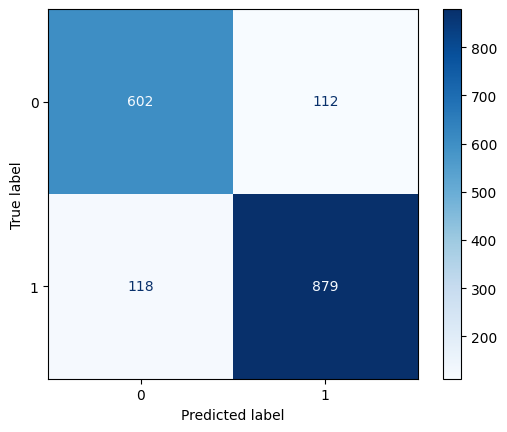

In [52]:
model_prediction(model_lstm, y_test_int)

## LSTM with Word2Vec

In [53]:
# Define a single input for sequences
input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

input_dim = len(model_word2vec.wv.key_to_index) + 1


# Updated embedding layer based on the Word2Vec model's vocabulary size
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=NUM_EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

embedded_sequence = embedding_layer(input_sequence)

# LSTM
shared_lstm = LSTM(NUM_LSTM_UNITS)
sequence_output = shared_lstm(embedded_sequence)

# Dense layer for classification
output_layer = Dense(units=NUM_CLASSES, activation='softmax')
predictions = output_layer(sequence_output)


# Model Creation
model_lstm_w2v = Model(inputs=input_sequence, outputs=predictions)

model_lstm_w2v.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 256)           7189760   
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 7387138 (28.18 MB)
Trainable params: 197378 (771.01 KB)
Non-trainable params: 7189760 (27.43 MB)
_________________________________________________________________


In [54]:
model_training(model_lstm_w2v, y_test_int)

Epoch 1/50
11/11 [==============================] - 4s 229ms/step - loss: 0.5904 - accuracy: 0.6925 - val_loss: 0.5624 - val_accuracy: 0.7146
Epoch 2/50
11/11 [==============================] - 2s 188ms/step - loss: 0.5195 - accuracy: 0.7606 - val_loss: 0.5168 - val_accuracy: 0.7613
Epoch 3/50
11/11 [==============================] - 3s 240ms/step - loss: 0.4799 - accuracy: 0.7804 - val_loss: 0.4873 - val_accuracy: 0.7562
Epoch 4/50
11/11 [==============================] - 3s 238ms/step - loss: 0.4619 - accuracy: 0.7873 - val_loss: 0.4898 - val_accuracy: 0.7686
Epoch 5/50
11/11 [==============================] - 2s 199ms/step - loss: 0.4467 - accuracy: 0.8024 - val_loss: 0.4969 - val_accuracy: 0.7796
Epoch 6/50
11/11 [==============================] - 2s 181ms/step - loss: 0.4335 - accuracy: 0.8130 - val_loss: 0.4693 - val_accuracy: 0.7759
Epoch 7/50
11/11 [==============================] - 2s 211ms/step - loss: 0.4222 - accuracy: 0.8161 - val_loss: 0.4700 - val_accuracy: 0.7788
Epoch 

54/54 [==============================] - 1s 9ms/step
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7750    0.7913    0.7831       714
           1     0.8483    0.8355    0.8418       997

    accuracy                         0.8171      1711
   macro avg     0.8117    0.8134    0.8125      1711
weighted avg     0.8177    0.8171    0.8173      1711

--------------------------------------------------------------------------------


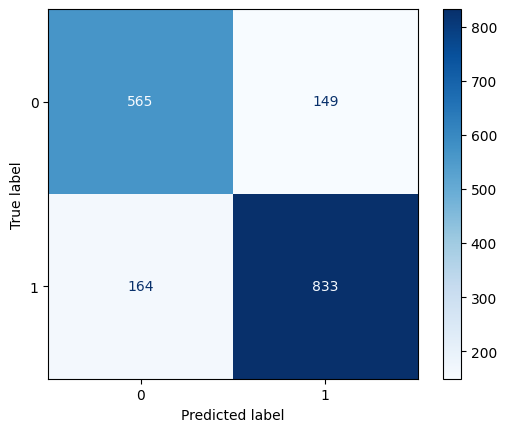

In [55]:
model_prediction(model_lstm_w2v, y_test_int)

## CNN

In [56]:
# Define the first input layer
input_sequence = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')


# Create branches for each input
embedded_sequence  = Embedding(input_dim=MAX_NUM_WORDS, output_dim=NUM_EMBEDDING_DIM)(input_sequence)
conv1d_layer  = Conv1D(32, kernel_size=3, activation='relu')(embedded_sequence)
maxpooling_layer  = MaxPooling1D(pool_size=2)(conv1d_layer)
flattened_layer  = Flatten()(maxpooling_layer)


# Additional processing layers
dense_layer  = Dense(64, activation='relu')(flattened_layer)

# Output layer
output = Dense(NUM_CLASSES, activation='softmax')(dense_layer)

# Create the model
model_cnn = Model(inputs=input_sequence, outputs=output)

model_cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 30, 256)           2560000   
                                                                 
 conv1d (Conv1D)             (None, 28, 32)            24608     
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                28736     
                                                           

In [57]:
model_training(model_cnn, y_test_int)

Epoch 1/50
11/11 [==============================] - 2s 100ms/step - loss: 0.6672 - accuracy: 0.5760 - val_loss: 0.6375 - val_accuracy: 0.6000
Epoch 2/50
11/11 [==============================] - 1s 61ms/step - loss: 0.5513 - accuracy: 0.7177 - val_loss: 0.5317 - val_accuracy: 0.7416
Epoch 3/50
11/11 [==============================] - 1s 69ms/step - loss: 0.3471 - accuracy: 0.8751 - val_loss: 0.3640 - val_accuracy: 0.8555
Epoch 4/50
11/11 [==============================] - 1s 63ms/step - loss: 0.1515 - accuracy: 0.9545 - val_loss: 0.3139 - val_accuracy: 0.8759
Epoch 5/50
11/11 [==============================] - 1s 74ms/step - loss: 0.0611 - accuracy: 0.9803 - val_loss: 0.3443 - val_accuracy: 0.8839
Epoch 6/50
11/11 [==============================] - 1s 81ms/step - loss: 0.0277 - accuracy: 0.9929 - val_loss: 0.3797 - val_accuracy: 0.8788
Epoch 7/50
11/11 [==============================] - 1s 63ms/step - loss: 0.0155 - accuracy: 0.9949 - val_loss: 0.3999 - val_accuracy: 0.8788
Epoch 8/50
1

54/54 [==============================] - 0s 2ms/step
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8517    0.8529    0.8523       714
           1     0.8946    0.8937    0.8941       997

    accuracy                         0.8767      1711
   macro avg     0.8732    0.8733    0.8732      1711
weighted avg     0.8767    0.8767    0.8767      1711

--------------------------------------------------------------------------------


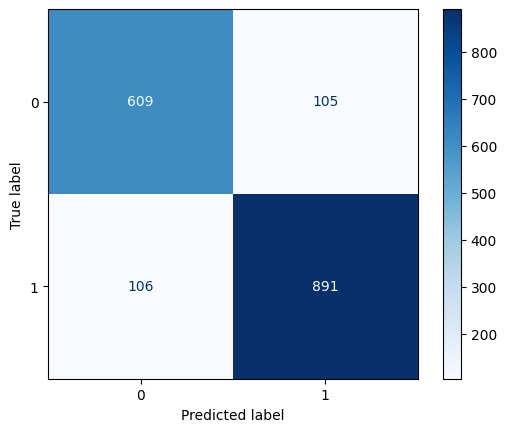

In [58]:
model_prediction(model_cnn, y_test_int)

## CNN with Word2Vec

In [59]:
# Define the first input layer
input_sequence = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# Updated embedding layer based on the Word2Vec model's vocabulary size
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=NUM_EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

# Create branches for each input
embedded_sequence  = embedding_layer(input_sequence)
conv1d_layer  = Conv1D(32, kernel_size=3, activation='relu')(embedded_sequence)
maxpooling_layer  = MaxPooling1D(pool_size=2)(conv1d_layer)
flattened_layer  = Flatten()(maxpooling_layer)


# Additional processing layers
dense_layer  = Dense(64, activation='relu')(flattened_layer)

# Output layer
output = Dense(NUM_CLASSES, activation='softmax')(dense_layer)

# Create the model
model_cnn_w2v = Model(inputs=input_sequence, outputs=output)

model_cnn_w2v.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 30, 256)           7189760   
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 32)            24608     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 448)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                28736     
                                                           

In [60]:
model_training(model_cnn_w2v, y_test_int)

Epoch 1/50
11/11 [==============================] - 1s 63ms/step - loss: 0.6190 - accuracy: 0.6504 - val_loss: 0.5821 - val_accuracy: 0.6971
Epoch 2/50
11/11 [==============================] - 0s 29ms/step - loss: 0.5305 - accuracy: 0.7508 - val_loss: 0.5340 - val_accuracy: 0.7526
Epoch 3/50
11/11 [==============================] - 0s 30ms/step - loss: 0.4783 - accuracy: 0.7877 - val_loss: 0.5055 - val_accuracy: 0.7672
Epoch 4/50
11/11 [==============================] - 0s 29ms/step - loss: 0.4375 - accuracy: 0.8048 - val_loss: 0.4899 - val_accuracy: 0.7686
Epoch 5/50
11/11 [==============================] - 0s 31ms/step - loss: 0.4107 - accuracy: 0.8227 - val_loss: 0.4934 - val_accuracy: 0.7693
Epoch 6/50
11/11 [==============================] - 0s 32ms/step - loss: 0.3880 - accuracy: 0.8324 - val_loss: 0.4820 - val_accuracy: 0.7679
Epoch 7/50
11/11 [==============================] - 0s 30ms/step - loss: 0.3670 - accuracy: 0.8452 - val_loss: 0.4896 - val_accuracy: 0.7686
Epoch 8/50
11

54/54 [==============================] - 0s 2ms/step
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7391    0.7815    0.7597       714
           1     0.8368    0.8024    0.8193       997

    accuracy                         0.7937      1711
   macro avg     0.7879    0.7920    0.7895      1711
weighted avg     0.7960    0.7937    0.7944      1711

--------------------------------------------------------------------------------


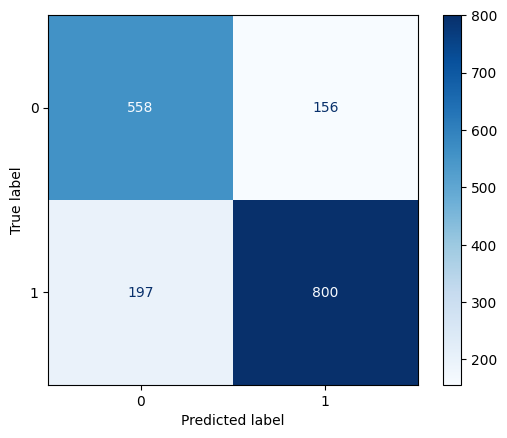

In [61]:
model_prediction(model_cnn_w2v, y_test_int)

## CNN-LSTM

In [62]:
# Define the input layer for sequences
input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Embedding layer for sequences
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM)(input_sequence)

# CNN branch
conv1d_layer = Conv1D(32, kernel_size=3, activation='relu')(embedding_layer)
maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
cnn_flattened_layer = Flatten()(maxpooling_layer)

# LSTM branch
lstm_layer = LSTM(NUM_LSTM_UNITS)(embedding_layer)

# Concatenate the output of CNN and LSTM branches
merged = concatenate([cnn_flattened_layer, lstm_layer])

# Additional Dense layer for combined features
dense_layer = Dense(64, activation='relu')(merged)

# Output layer
output = Dense(NUM_CLASSES, activation='softmax')(dense_layer)

# Create the model
model_cnnlstm = Model(inputs=input_sequence, outputs=output)

model_cnnlstm.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 30, 256)              2560000   ['input_5[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 28, 32)               24608     ['embedding_4[0][0]']         
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 14, 32)               0         ['conv1d_2[0][0]']            
 g1D)                                                                                       

In [63]:
model_training(model_cnnlstm, y_test_int)

Epoch 1/50
11/11 [==============================] - 5s 330ms/step - loss: 0.6434 - accuracy: 0.6253 - val_loss: 0.5880 - val_accuracy: 0.7022
Epoch 2/50
11/11 [==============================] - 3s 306ms/step - loss: 0.4104 - accuracy: 0.8318 - val_loss: 0.3398 - val_accuracy: 0.8693
Epoch 3/50
11/11 [==============================] - 3s 296ms/step - loss: 0.1900 - accuracy: 0.9293 - val_loss: 0.2981 - val_accuracy: 0.8861
Epoch 4/50
11/11 [==============================] - 3s 276ms/step - loss: 0.0851 - accuracy: 0.9712 - val_loss: 0.3250 - val_accuracy: 0.8832
Epoch 5/50
11/11 [==============================] - 3s 303ms/step - loss: 0.0377 - accuracy: 0.9874 - val_loss: 0.3909 - val_accuracy: 0.8788
Epoch 6/50
11/11 [==============================] - 3s 307ms/step - loss: 0.0190 - accuracy: 0.9936 - val_loss: 0.4474 - val_accuracy: 0.8781
Epoch 7/50
11/11 [==============================] - 3s 319ms/step - loss: 0.0113 - accuracy: 0.9963 - val_loss: 0.5088 - val_accuracy: 0.8745
Epoch 

54/54 [==============================] - 1s 10ms/step
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8671    0.8403    0.8535       714
           1     0.8881    0.9077    0.8978       997

    accuracy                         0.8796      1711
   macro avg     0.8776    0.8740    0.8757      1711
weighted avg     0.8793    0.8796    0.8793      1711

--------------------------------------------------------------------------------


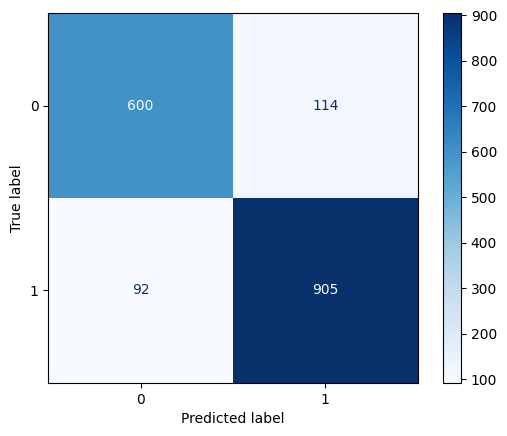

In [64]:
model_prediction(model_cnnlstm, y_test_int)

## CNN-LSTM with Word2Vec

In [65]:
# Define the input layer for sequences
input_sequence = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# Updated embedding layer based on the Word2Vec model's vocabulary size
embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=NUM_EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

# Embedding layer for sequences
embedding_layer = embedding_layer(input_sequence)

# CNN branch
conv1d_layer = Conv1D(32, kernel_size=3, activation='relu')(embedding_layer)
maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
cnn_flattened_layer = Flatten()(maxpooling_layer)

# LSTM branch
lstm_layer = LSTM(NUM_LSTM_UNITS)(embedding_layer)

# Concatenate the output of CNN and LSTM branches
merged = concatenate([cnn_flattened_layer, lstm_layer])

# Additional Dense layer for combined features
dense_layer = Dense(64, activation='relu')(merged)

# Output layer
output = Dense(NUM_CLASSES, activation='softmax')(dense_layer)

# Create the model
model_cnnlstm_w2v = Model(inputs=input_sequence, outputs=output)

model_cnnlstm_w2v.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 30, 256)              7189760   ['input_6[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 28, 32)               24608     ['embedding_5[0][0]']         
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 14, 32)               0         ['conv1d_3[0][0]']            
 g1D)                                                                                       

In [66]:
model_training(model_cnnlstm_w2v, y_test_int)

Epoch 1/50
11/11 [==============================] - 5s 252ms/step - loss: 0.5817 - accuracy: 0.6923 - val_loss: 0.5383 - val_accuracy: 0.7409
Epoch 2/50
11/11 [==============================] - 2s 209ms/step - loss: 0.4821 - accuracy: 0.7871 - val_loss: 0.4919 - val_accuracy: 0.7672
Epoch 3/50
11/11 [==============================] - 2s 206ms/step - loss: 0.4291 - accuracy: 0.8110 - val_loss: 0.4863 - val_accuracy: 0.7708
Epoch 4/50
11/11 [==============================] - 2s 201ms/step - loss: 0.3989 - accuracy: 0.8214 - val_loss: 0.4763 - val_accuracy: 0.7861
Epoch 5/50
11/11 [==============================] - 2s 199ms/step - loss: 0.3753 - accuracy: 0.8399 - val_loss: 0.4682 - val_accuracy: 0.7920
Epoch 6/50
11/11 [==============================] - 2s 202ms/step - loss: 0.3519 - accuracy: 0.8448 - val_loss: 0.4668 - val_accuracy: 0.7934
Epoch 7/50
11/11 [==============================] - 2s 197ms/step - loss: 0.3339 - accuracy: 0.8638 - val_loss: 0.4690 - val_accuracy: 0.7956
Epoch 

54/54 [==============================] - 1s 14ms/step
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8104    0.7423    0.7749       714
           1     0.8259    0.8756    0.8500       997

    accuracy                         0.8200      1711
   macro avg     0.8182    0.8090    0.8125      1711
weighted avg     0.8194    0.8200    0.8187      1711

--------------------------------------------------------------------------------


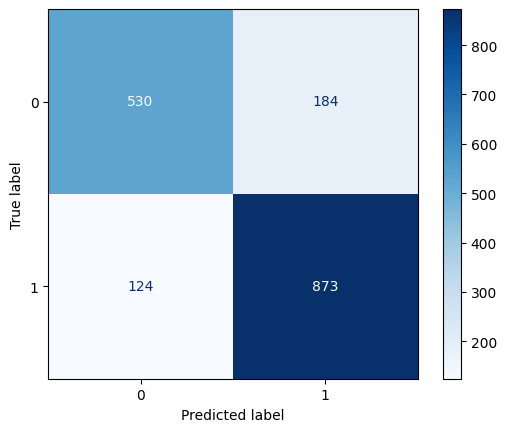

In [67]:
model_prediction(model_cnnlstm_w2v, y_test_int)

# Evaluation

In [68]:
models = ["LSTM", "LSTM with Word2Vec", "CNN", "CNN with Word2Vec", "CNN-LSTM", "CNN-LSTM with Word2Vec"]

metrics_dict = {
    'Model': models,
    'Accuracy, %': accuracies,
    'Precision, %': precisions,
    'Recall, %': recalls,
    'F1 Score, %': f1_scores
}

# Convert the dictionary to a DataFrame
metrics_comparison = pd.DataFrame(metrics_dict)

# Display the DataFrame
metrics_comparison

,Model,"Accuracy, %","Precision, %","Recall, %","F1 Score, %"
0,LSTM,86.56,88.70,88.16,88.43
1,LSTM with Word2Vec,81.71,84.83,83.55,84.18
2,CNN,87.67,89.46,89.37,89.41
3,CNN with Word2Vec,79.37,83.68,80.24,81.93
4,CNN-LSTM,87.96,88.81,90.77,89.78
5,CNN-LSTM with Word2Vec,82.00,82.59,87.56,85.00


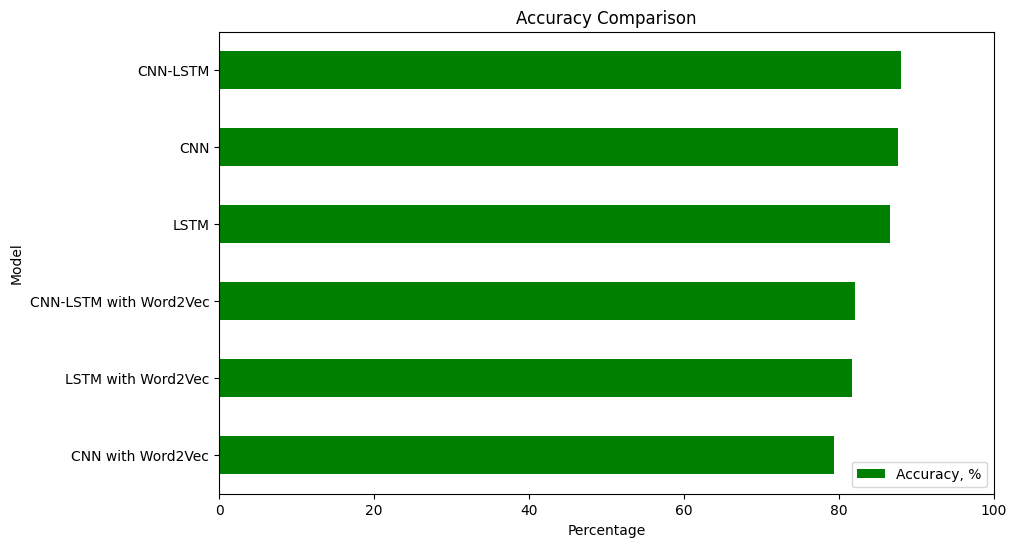

In [76]:
# Sort DataFrame by 'Accuracy, %' in descending order
metrics_comparison.sort_values(by='Accuracy, %', ascending=True, inplace=True)

# Plotting (horizontal bar chart)
metrics_comparison.plot(kind='barh', x="Model", y='Accuracy, %', figsize=(10, 6), color='green')
plt.title('Accuracy Comparison')
plt.xlabel('Percentage')
plt.ylabel('Model')
plt.xlim(0, 100)  # Adjust the x-axis range if needed
plt.legend(loc='lower right')
plt.show()

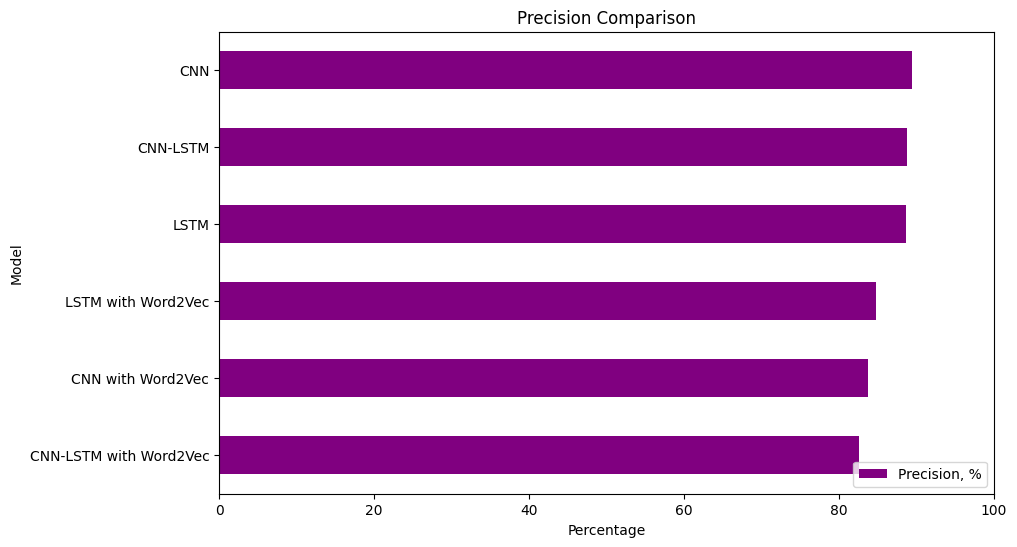

In [77]:
# Sort DataFrame by 'Accuracy, %' in descending order
metrics_comparison.sort_values(by='Precision, %', ascending=True, inplace=True)

# Plotting (horizontal bar chart)
metrics_comparison.plot(kind='barh', x="Model", y='Precision, %', figsize=(10, 6), color='Purple')
plt.title('Precision Comparison')
plt.xlabel('Percentage')
plt.ylabel('Model')
plt.xlim(0, 100)  # Adjust the x-axis range if needed
plt.legend(loc='lower right')
plt.show()

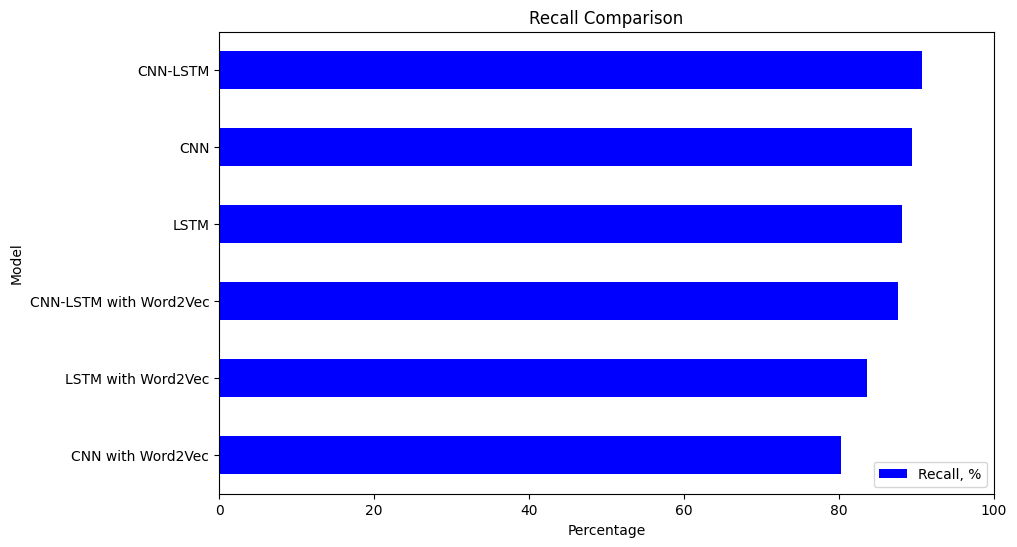

In [74]:
# Sort DataFrame by 'Accuracy, %' in descending order
metrics_comparison.sort_values(by='Recall, %', ascending=True, inplace=True)

# Plotting (horizontal bar chart)
metrics_comparison.plot(kind='barh', x="Model", y='Recall, %', figsize=(10, 6), color='Blue')
plt.title('Recall Comparison')
plt.xlabel('Percentage')
plt.ylabel('Model')
plt.xlim(0, 100)  # Adjust the x-axis range if needed
plt.legend(loc='lower right')
plt.show()

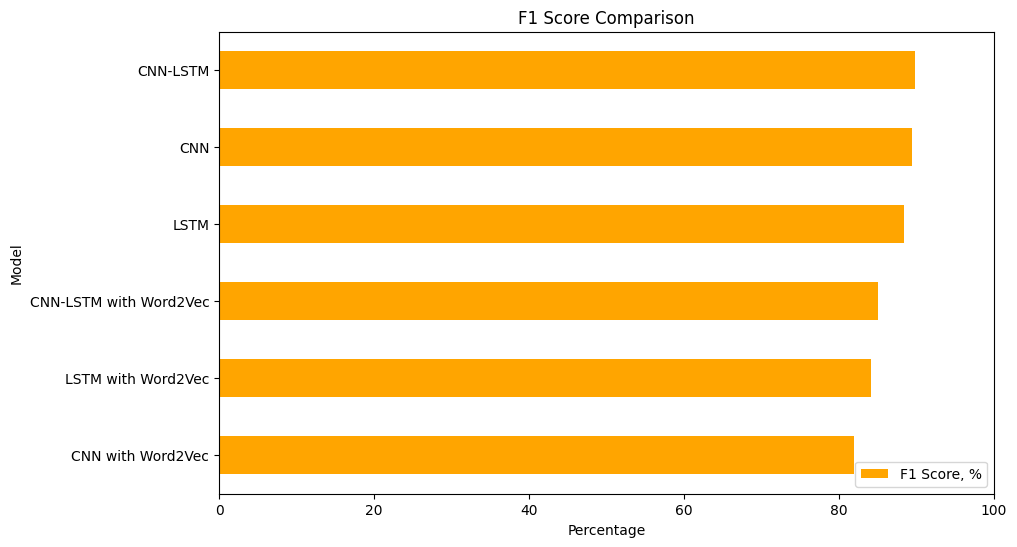

In [73]:
# Sort DataFrame by 'Accuracy, %' in descending order
metrics_comparison.sort_values(by='F1 Score, %', ascending=True, inplace=True)

# Plotting (horizontal bar chart)
metrics_comparison.plot(kind='barh', x="Model", y='F1 Score, %', figsize=(10, 6), color='Orange')
plt.title('F1 Score Comparison')
plt.xlabel('Percentage')
plt.ylabel('Model')
plt.xlim(0, 100)  # Adjust the x-axis range if needed
plt.legend(loc='lower right')
plt.show()

# Deployment (Streamlit)